# 가설 : 집값이 낮을 수록 범죄율이 높다

## 정의
###   집값은 아파트 평균 매매가격을 기준으로 한다.
###   범죄의 기준은 5대 범죄(살인, 강도, 강간추행,절도, 폭력)로 설정한다.
###   범죄율은 범죄발생건수/주민등록상 등록인구수를 구단위로 나눈다.
####   2019년 7월 1일

In [1]:
# 1. 라이브러리 호출
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
# 2. 시각화 설정
from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline
# 3. 한글폰트를 설정(한글을 사용한다면 반드시 사용)
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
# 4. 해상도 설정
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
def house_price_preprocessing(path):
    row_price = pd.read_excel(path, skiprows=10)
    
    big_col = []
    for num, temp in enumerate(row_price['지 역']):
        if pd.isna(temp) :
            big_col.append(big_col[num-1])
        else:
            big_col.append(temp)

    small_col = []
    for num in range(len(row_price)):
        temp_list = list(row_price[['지 역', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']].iloc[num])
        for temp in temp_list[3::-1]:
            if not pd.isna(temp):
                small_col.append(temp)
                break

    row_price.index = [big_col, small_col]
    
    transposed_price = row_price.drop(['지 역', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], axis=1).T
    
    time_index = []
    for time in transposed_price.index:
        temp = time.split(' ')
        time_index.append(temp[0][:-1]+'.'+temp[1][:-1])

    transposed_price.index = pd.to_datetime(time_index)
    
    return transposed_price

In [3]:
price_path = f'data/평균매매가격_아파트.xlsx'
people_path = f'data/자치구단위 서울 생활인구 일별 집계표.xlsx'
crime_path = f'data/서울시 범죄현황 통계.xlsx'

# 서울 평균 아파트 매매가격 : 2019-07-01

In [4]:
price_df = house_price_preprocessing(price_path)
price_seoul=price_df['서울'].copy()
del price_seoul['서울']
del price_seoul['강북지역']
del price_seoul['도심권']
del price_seoul['동북권']
del price_seoul['서북권']
del price_seoul['강남지역']
del price_seoul['서남권']
del price_seoul['동남권']
price_seoul=price_seoul.loc['2019-7-1']

In [5]:
price_seoul

종로구      709250
중구       768833
용산구     1364605
성동구      863255
광진구      896184
동대문구     584181
중랑구      442080
성북구      553717
강북구      478667
도봉구      426387
노원구      441857
은평구      533233
서대문구     606607
마포구      832408
양천구      792022
강서구      576169
구로구      525191
금천구      403266
영등포구     770630
동작구      792908
관악구      492174
서초구     1527097
강남구     1584787
송파구     1102847
강동구      702968
Name: 2019-07-01 00:00:00, dtype: int64

# 서울 각 생활 인구 기준일 : 2019-07-01

In [6]:
def people_preprocessing(people_path):
    raw_people=pd.read_excel(people_path, sheet_name='자치구단위 서울 생활인구 일별 집계표')
    raw_people=raw_people[['기준일ID','시군구명','총생활인구수']]
    raw_people.columns=['기준일','구군','생활인구수']
    raw_people=raw_people[raw_people['기준일']==20190701]
    raw_people=raw_people.reset_index()
    raw_people=raw_people.drop(raw_people.index[0])
    raw_people=raw_people[['구군','생활인구수']]
    raw_people=raw_people.set_index('구군')
    raw_people=raw_people.round()
    return raw_people

In [7]:
raw_people = people_preprocessing(people_path)
raw_people

,생활인구수
구군,
종로구,335179.0
중구,374990.0
용산구,315237.0
성동구,353182.0
광진구,387986.0
동대문구,376207.0
중랑구,345476.0
성북구,422060.0
강북구,287952.0


# 서울시 범죄율

In [8]:
def crime_preprocessing(crime_path):
    raw_crime=pd.read_excel(crime_path, sheet_name='Sheet1', skiprows=1)
    raw_crime=raw_crime[['자치구','발생']]
    raw_crime.columns=['구군','범죄건수']
    raw_crime=raw_crime.set_index('구군')
    raw_crime=raw_crime.drop(raw_crime.index[0])

In [9]:
raw_result=raw_crime.copy()
raw_result

,범죄건수
구군,
종로구,3690
중구,4030
용산구,3411
성동구,2457
광진구,3915
동대문구,3680
중랑구,4288
성북구,3042
강북구,3437


In [10]:
raw_result['범죄율']=(raw_crime['범죄건수']/raw_people['생활인구수'])*100
raw_result['아파트평균매매가격']=price_seoul
raw_result=raw_result[['범죄율', '아파트평균매매가격']].copy()
raw_result

,범죄율,아파트평균매매가격
구군,,
종로구,1.100904,709250
중구,1.074695,768833
용산구,1.082043,1364605
성동구,0.695675,863255
광진구,1.009057,896184
동대문구,0.978185,584181
중랑구,1.241186,442080
성북구,0.720751,553717
강북구,1.193602,478667


In [11]:
raw_result.info

<bound method DataFrame.info of            범죄율  아파트평균매매가격
구군                       
종로구   1.100904     709250
중구    1.074695     768833
용산구   1.082043    1364605
성동구   0.695675     863255
광진구   1.009057     896184
동대문구  0.978185     584181
중랑구   1.241186     442080
성북구   0.720751     553717
강북구   1.193602     478667
도봉구   0.816731     426387
노원구   0.803844     441857
은평구   0.836407     533233
서대문구  0.702076     606607
마포구   1.044808     832408
양천구   0.910091     792022
강서구   0.846971     576169
구로구   1.144472     525191
금천구   1.344938     403266
영등포구  1.138770     770630
동작구   0.770918     792908
관악구   1.017475     492174
서초구   0.764173    1527097
강남구   0.857532    1584787
송파구   0.765526    1102847
강동구   0.828909     702968>

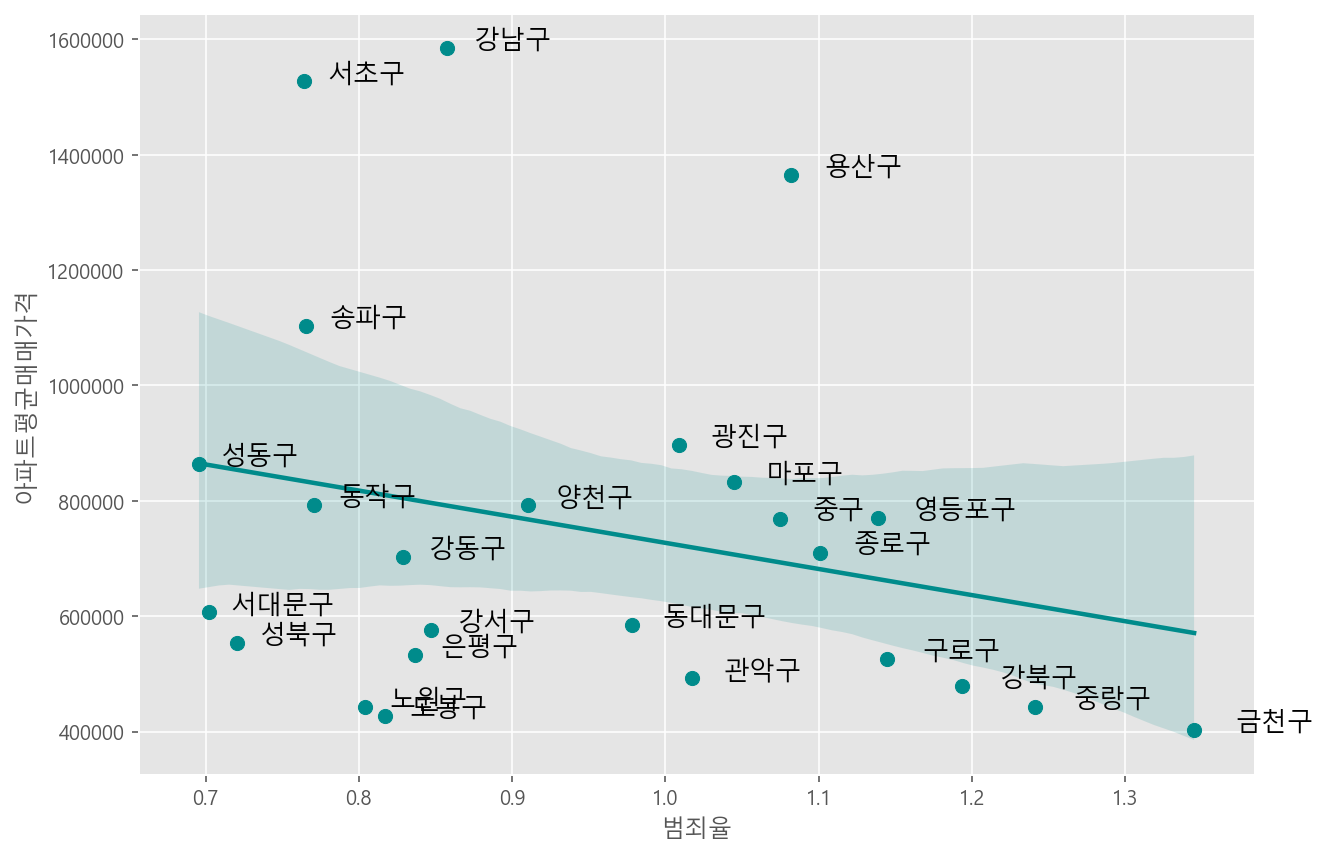

In [12]:
plt.figure(figsize=(10, 7))
plt.scatter(raw_result['범죄율'], raw_result['아파트평균매매가격'], color='darkcyan', s=50)
sns.regplot(raw_result['범죄율'], raw_result['아파트평균매매가격'], scatter=False, color='darkcyan')
plt.xlabel('범죄율')
plt.ylabel('아파트평균매매가격')
for name in raw_result.index:
    plt.text(raw_result['범죄율'][name]*1.02, raw_result['아파트평균매매가격'][name], name, fontsize=13)        
plt.show()

# 지도 시각화로 표현한 서울시 집값과 범죄율 

In [13]:
import json
geo_path=f'data/part3_seoul_municipalities_geo_simple.json'
geo_json = json.load(open(geo_path, encoding="utf-8"))
geo_json['features'][0]['properties']['name']

'강동구'

In [14]:
map_crime = folium.Map(location=[37.5502, 126.982],zoom_start=11, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_json,
    name='범죄율',
    data=raw_result,
    columns=[raw_result.index,'범죄율'],
    key_on='feature.properties.name',
    fill_color='PuRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='범죄율'
).add_to(map_crime)
map_crime.save('crimemap.html')
map_crime

In [15]:
map_house_price = folium.Map(location=[37.5502, 126.982],zoom_start=11, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_json,
    name='아파트평균매매가격',
    data=raw_result,
    columns=[raw_result.index,'아파트평균매매가격'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='아파트평균매매가격'
).add_to(map_house_price)
map_house_price.save('hpricemap.html')
map_house_price

### 결론 : 전체 평균을 내었을때 범죄율이 오를 수록 집값은 낮아지는 경향은 보이나 그 정도는 낮다고 볼 수 있다. 오히려 서초구와 강남구 같은 비정상적으로 높은 곳의 집값으로 인해 데이터가 왜곡된 면도 없지 않아 있다. 가설은 예외상황이 많기에 보편적으로 적용할 수 없어 틀렸다고 할 수 있다.

### 번외 : 절도와 강도는 좀더 연관이 있지 않을까 해보았지만 더 없었다.

TMI : 경주는 작년 살인사건이 단 두건밖에 일어나지 않았지만 인천은 토막살인사건이 빈번하게 일어난다. 이런 결과에 대해 추정해보기를 경주는 외국인노동자와 유대가 높은 토착민 커뮤니티가 구성되어 있지만 인천은 외지인의 비율이 높으며 구성원들간의 유대가 낮은편에 속한다. 범죄율은 단순히 집값보다 여러 외부 요인이 작용하는 것으로 보인다.